In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import wordnet
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('DATA/맞춤법완료.csv', encoding='utf-8')

In [3]:
df = df[df['감정'] != 'Unknown']

In [4]:
df['감정'].value_counts()

감정
감사한     45364
만족한     22707
힐링되는    11197
신나는      4645
경험적인     1673
불만족      1061
양가감정      964
Name: count, dtype: int64

In [5]:
target_emotions = ['양가감정', '경험적인', '불만족']
filtered_df = df[df['감정'].isin(target_emotions)]

In [6]:
# 무작위 삽입을 위한 유의어 함수
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char.isalpha() or char == ' '])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

In [7]:
def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

# 단어 순서 변경 함수
def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        if counter > 3:
            return new_words
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

In [8]:
# 증강된 데이터 생성
def augment_sentence(sentence):
    words = sentence.split(' ')
    words = [word for word in words if word != '']
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = 1 

    augmented_sentences.append(' '.join(random_insertion(words, int(0.1*num_words))))
    augmented_sentences.append(' '.join(random_swap(words, int(0.1*num_words))))

    return augmented_sentences[:3]  # 3개의 변형 문장만 추가

In [9]:
# 증강된 데이터를 저장할 리스트
augmented_texts = []
augmented_ids = []
augmented_ratings = []
augmented_dates = []
augmented_join_periods = []
augmented_translation_status = []
augmented_reply_dates = []
augmented_replies = []
augmented_guest_preferences = []
augmented_super_hosts = []
augmented_categories = []
augmented_regions = []
augmented_sentiments = []
augmented_emotions = []

In [10]:
# '리뷰_교정' 데이터를 대상으로 증강
for index, row in filtered_df.iterrows():  # 감정이 '불만족', '양가감정', '경험적인' 데이터만 필터링
    review_text = row['리뷰_교정'] if isinstance(row['리뷰_교정'], str) else '' 
    augmented_sentences = augment_sentence(review_text)
    
    # 기존 데이터를 유지하면서 증강된 데이터를 추가
    augmented_texts.extend(augmented_sentences)
    augmented_ids.extend([row['id']] * len(augmented_sentences))
    augmented_ratings.extend([row['평점']] * len(augmented_sentences))
    augmented_dates.extend([row['날짜']] * len(augmented_sentences))
    augmented_join_periods.extend([row['가입기간']] * len(augmented_sentences))
    augmented_translation_status.extend([row['번역여부']] * len(augmented_sentences))
    augmented_reply_dates.extend([row['답글 날짜']] * len(augmented_sentences))
    augmented_replies.extend([row['답글']] * len(augmented_sentences))
    augmented_guest_preferences.extend([row['게스트 선호']] * len(augmented_sentences))
    augmented_super_hosts.extend([row['슈퍼 호스트']] * len(augmented_sentences))
    augmented_categories.extend([row['카테고리']] * len(augmented_sentences))
    augmented_regions.extend([row['지역']] * len(augmented_sentences))
    augmented_sentiments.extend([row['감정']] * len(augmented_sentences))
    augmented_emotions.extend([row['감성']] * len(augmented_sentences))

In [11]:
# 증강된 데이터 통합
augmented_df = pd.DataFrame({
    'id': augmented_ids,
    '평점': augmented_ratings,
    '날짜': augmented_dates,
    '가입기간': augmented_join_periods,
    '리뷰_교정': augmented_texts,
    '번역여부': augmented_translation_status,
    '답글 날짜': augmented_reply_dates,
    '답글': augmented_replies,
    '게스트 선호': augmented_guest_preferences,
    '슈퍼 호스트': augmented_super_hosts,
    '카테고리': augmented_categories,
    '지역': augmented_regions,
    '감정': augmented_sentiments,
    '감성': augmented_emotions
})

In [12]:
final_df = pd.concat([df, augmented_df], ignore_index=True)

In [13]:
final_df = final_df[['id', '평점', '날짜', '가입기간', '리뷰_교정', '번역여부', '호스트', '답글 날짜', '답글', 
                     '게스트 선호', '슈퍼 호스트', '카테고리', '지역', '감정', '감성']]

In [14]:
final_df

,id,평점,날짜,가입기간,리뷰_교정,번역여부,호스트,답글 날짜,답글,게스트 선호,슈퍼 호스트,카테고리,지역,감정,감성
0,Chole,5,1주 전,7년,사진이 버스와 일치하는 경우 호스트의 안내가 매우 명확하고 위치를 쉽게 찾을 수 있...,중국어,답변 없음,답변 없음,답변 없음,X,슈퍼 호스트,B&B,서울,감사한,행복한
1,露露,5,1주 전,5년,집주인은 매우 잘생기고 언어가 많으며 중국어로 의사소통이 매우 원활하고 원활합니다 ...,중국어,답변 없음,답변 없음,답변 없음,X,슈퍼 호스트,B&B,서울,감사한,행복한
2,Haonan,5,3주 전,2개월,호스트는 매우 친절하고 의사소통이 잘됩니다 다음에 이곳에 다시 묵을 귀여운 고양이도...,중국어,답변 없음,답변 없음,답변 없음,X,슈퍼 호스트,B&B,서울,감사한,행복한
3,Kiki,5,2024년 7월,2년,멋진 숙박을 했습니다 숙소는 멋지고 고양이는 사랑스럽습니다 제이와 그의 아내는 놀라...,영어,답변 없음,답변 없음,답변 없음,X,슈퍼 호스트,B&B,서울,감사한,행복한
4,Grace,5,2024년 6월,4개월,훌륭한 숙박객실은 매우 깨끗하고 넓습니다 욕실은 적절하며 주방에는 토스터 온수 식수...,영어,답변 없음,답변 없음,답변 없음,X,슈퍼 호스트,B&B,서울,만족한,행복한
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95002,郁婷,5,2024년 5월,5년,에서 숙소는 떨어져 있지만 약간 깨끗하고 최선을 다해 관리했습니다 하지만 베개가 엉...,중국어,NaN,답변 없음,답변 없음,X,슈퍼 호스트,한옥,서울,양가감정,우울한
95003,Michel,4,2024년 5월,10년,작은 방바닥에 이불이 있고 샤워실 화장실 세면대 방이 있습니다 이 동네는 지하철 1...,프랑스어,NaN,답변 없음,답변 없음,X,슈퍼 호스트,한옥,서울,경험적인,행복한
95004,Michel,4,2024년 5월,10년,작은 방바닥에 이불이 있고 샤워실 화장실 세면대 방이 있습니다 예쁩니다 동네는 지하...,프랑스어,NaN,답변 없음,답변 없음,X,슈퍼 호스트,한옥,서울,경험적인,행복한
95005,Daphné,5,2023년 8월,4년,69달러는 한옥의 작은방에서 자기에 조금 비쌌을 수도 있지만 정말 체험을 해보고 싶...,프랑스어,NaN,답변 없음,답변 없음,X,슈퍼 호스트,한옥,서울,양가감정,양가감정


In [39]:
final_df.to_csv('DATA/new/증강된 데이터.csv', index=False, encoding='utf-8')

In [40]:
# final_df.to_excel('증강된 데이터.xlsx', sheet_name='sheet1')

In [41]:
df['감정'].value_counts()

감정
감사한     45364
만족한     22707
힐링되는    11197
신나는      4645
경험적인     1673
불만족      1061
양가감정      964
Name: count, dtype: int64

In [42]:
final_df['감정'].value_counts()

감정
감사한     45364
만족한     22707
힐링되는    11197
경험적인     5019
신나는      4645
불만족      3183
양가감정     2892
Name: count, dtype: int64

In [43]:
final_df.tail()

,id,평점,날짜,가입기간,리뷰_교정,번역여부,호스트,답글 날짜,답글,게스트 선호,슈퍼 호스트,카테고리,지역,감정,감성
95002,郁婷,5,2024년 5월,5년,에서 약간 떨어져 있지만 숙소는 깨끗하고 최선을 않았어요 관리했습니다 하지만 베개가...,중국어,NaN,답변 없음,답변 없음,X,슈퍼 호스트,한옥,서울,양가감정,우울한
95003,Michel,4,2024년 5월,10년,작은 방바닥에 이불이 있고 샤워실 화장실 세면대 방이 있습니다 이 동네는 지하철 1...,프랑스어,NaN,답변 없음,답변 없음,X,슈퍼 호스트,한옥,서울,경험적인,행복한
95004,Michel,4,2024년 5월,10년,1호선에서 방바닥에 이불이 있고 샤워실 화장실 세면대 방이 있습니다 이 동네는 지하...,프랑스어,NaN,답변 없음,답변 없음,X,슈퍼 호스트,한옥,서울,경험적인,행복한
95005,Daphné,5,2023년 8월,4년,69달러는 한옥의 작은방에서 자기에 조금 비쌌을 수도 있지만 정말 체험을 해보고 싶...,프랑스어,NaN,답변 없음,답변 없음,X,슈퍼 호스트,한옥,서울,양가감정,양가감정
95006,Daphné,5,2023년 8월,4년,69달러는 한옥의 작은방에서 있지만 조금 비쌌을 수도 자기에 정말 체험을 해보고 싶...,프랑스어,NaN,답변 없음,답변 없음,X,슈퍼 호스트,한옥,서울,양가감정,양가감정


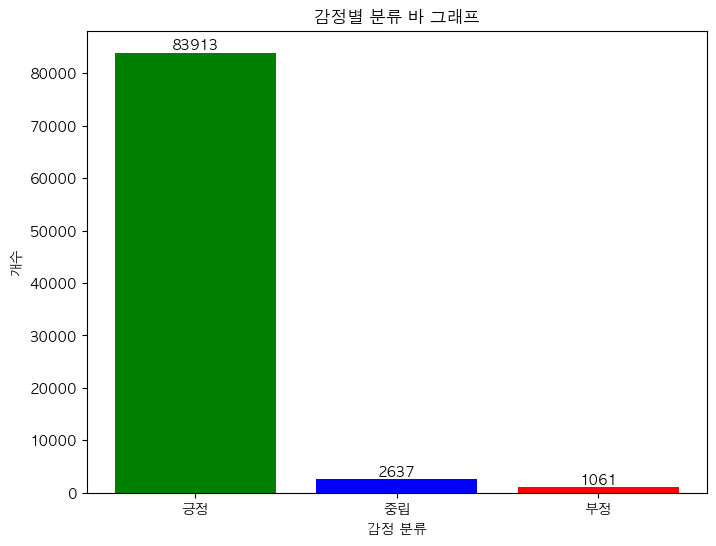

In [44]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'AppleGothic'

emotion_map = {
    '감사한': '긍정',
    '만족한': '긍정',
    '힐링되는': '긍정',
    '신나는': '긍정',
    '경험적인': '중립',
    '양가감정': '중립',
    '불만족': '부정'
}

df['감정_분류'] = df['감정'].map(emotion_map)
df = df.dropna(subset=['감정_분류'])

emotion_counts = df['감정_분류'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(emotion_counts.index, emotion_counts.values, color=['green', 'blue', 'red'])  # bars 객체 선언
plt.title('감정별 분류 바 그래프')
plt.xlabel('감정 분류')
plt.ylabel('개수')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

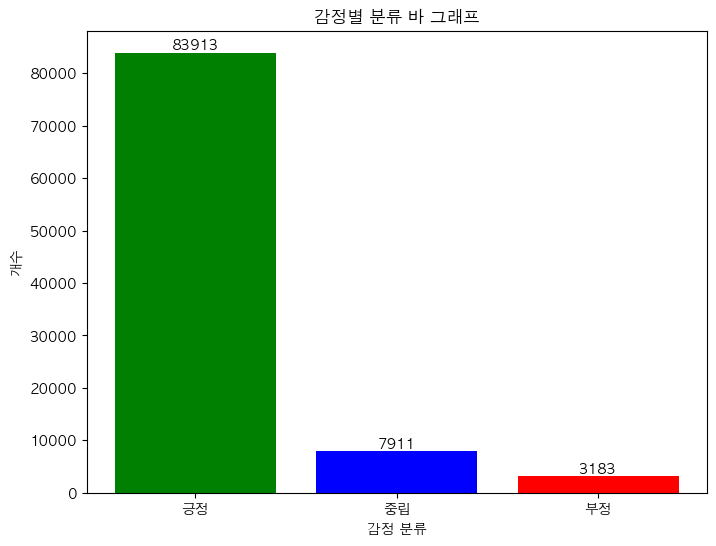

In [45]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'AppleGothic'

emotion_map = {
    '감사한': '긍정',
    '만족한': '긍정',
    '힐링되는': '긍정',
    '신나는': '긍정',
    '경험적인': '중립',
    '양가감정': '중립',
    '불만족': '부정'
}

final_df['감정_분류'] = final_df['감정'].map(emotion_map)
final_df = final_df.dropna(subset=['감정_분류'])

emotion_counts = final_df['감정_분류'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(emotion_counts.index, emotion_counts.values, color=['green', 'blue', 'red'])  # bars 객체 선언
plt.title('감정별 분류 바 그래프')
plt.xlabel('감정 분류')
plt.ylabel('개수')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()